# Prediction of shear strength in UHPC beams using machine learning-based models and SHAP interpretation

Meng Ye, Lifeng Li, Doo-Yeol Yoo, Huihui Li, Cong Zhou, Xudong Shao

data collected by Meng Ye

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
# define an additional metric 
def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / abs(true))

In [3]:
# impoting the database
from openpyxl import load_workbook
dataset = pd.read_excel('Shear strength_UHPC beams.xlsx')

dataset.head()

,h,b,bf1,tf1,bf2,tf2,Ac,ρl,fsy,ρp,...,s,ρsv,fsv,fc,ρf,lf,df,λf,m,Vu
0,220,120.0,0,0.0,0,0.0,26400.0,0.04,550.0,0.0,...,0.0,0.0,0.0,103.0,0.0,0.0,0.0,0.000000,2.5,107.0
1,220,120.0,0,0.0,0,0.0,26400.0,0.04,550.0,0.0,...,0.0,0.0,0.0,122.0,2.0,19.0,0.2,1.653571,2.5,184.0
2,220,120.0,0,0.0,0,0.0,26400.0,0.04,550.0,0.0,...,0.0,0.0,0.0,103.0,0.0,0.0,0.0,0.000000,3.0,42.5
3,220,120.0,0,0.0,0,0.0,26400.0,0.04,550.0,0.0,...,0.0,0.0,0.0,122.0,2.0,19.0,0.2,1.653571,3.0,177.0
4,220,120.0,0,0.0,0,0.0,26400.0,0.04,550.0,0.0,...,0.0,0.0,0.0,122.0,2.0,19.0,0.2,1.653571,3.0,177.5


In [4]:
# define the inputs and the output
X = dataset.loc[:, dataset.columns != 'Vu']
y = dataset.loc[:, 'Vu']

print(X.shape)
print(y.shape)

(532, 20)
(532,)


In [5]:
# normalizing the whole data sets
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [6]:
# randomly spliting the database into training-testing sets as 80%-20% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

# 1 ANN

In [7]:
# building the ANN model 

from sklearn.neural_network import MLPRegressor

regr1 = MLPRegressor(hidden_layer_sizes=(100,), max_iter=5000, random_state=10)

# 10-fold cv results for hyper-parameter validation
scores = cross_val_score (regr1, X_train, y_train, cv=10, scoring='r2', n_jobs = -1)
print('10-fold mean r2:', np.mean(scores))

10-fold mean r2: 0.879519571147461


In [8]:
# trainning the model
regr1.fit(X_train, y_train) 
Z_1 = regr1.predict(X_train)
Z_2 = regr1.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

Training R2: 0.9296074451984827 RMSE: 110.30055785314644 MAE: 69.75685558836365 MAPE: 27.24021239699074 %
Testing R2: 0.8941636851338539 RMSE: 118.50996236632017 MAE: 86.0277214474441 MAPE: 28.146251241126198 %


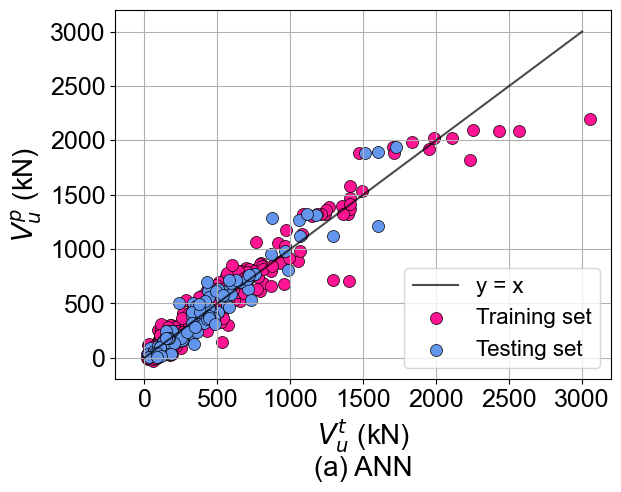

In [9]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

colors1 = 'deeppink' #点的颜色
colors2 = 'cornflowerblue'

plt.figure()
plt.title('(a) ANN',fontproperties = 'Arial', size = 20, y=-0.3, va='bottom', ha='center')
plt.plot(xx, yy, linewidth=1.5, c ='black', alpha=0.7)
plt.scatter(y_train, Z_1, marker='o', s=75, c=colors1, linewidth=0.5, edgecolors='black')
plt.scatter(y_test, Z_2, marker='o', s=75, c=colors2, linewidth=0.5, edgecolors='black')
plt.grid()

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Arial', size = 18)
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000], fontproperties = 'Arial', size = 18)

font1 = {'family' : 'Arial', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('$V_{u}^{t}$ (kN)', font1)
plt.ylabel('$V_{u}^{p}$ (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])

plt.legend(['y = x','Training set','Testing set'], loc = 'lower right', prop={'family' : 'Arial', 'weight' : 'normal', 'size' : 16,})

plt.savefig('Prediction_ANN.JPG', dpi=500, bbox_inches = 'tight')
plt.show()

# 2 SVR

In [10]:
# building the SVR model 
from sklearn.svm import SVR
regr2 = SVR(C=1500, gamma=0.01, kernel='rbf')

# 10-fold cv results for hyper-parameter validation
scores = cross_val_score (regr2, X_train, y_train, cv=10, scoring='r2', n_jobs = -1)
print('10-fold mean r2:', np.mean(scores))

10-fold mean r2: 0.8918361425311547


In [11]:
# trainning the model
regr2.fit(X_train, y_train) 
Z_1 = regr2.predict(X_train)
Z_2 = regr2.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

Training R2: 0.9208656080585351 RMSE: 116.94912584073562 MAE: 53.52710183198831 MAPE: 17.44690800442333 %
Testing R2: 0.9179017888090728 RMSE: 104.37689002710539 MAE: 64.42454117329068 MAPE: 21.45612951755178 %


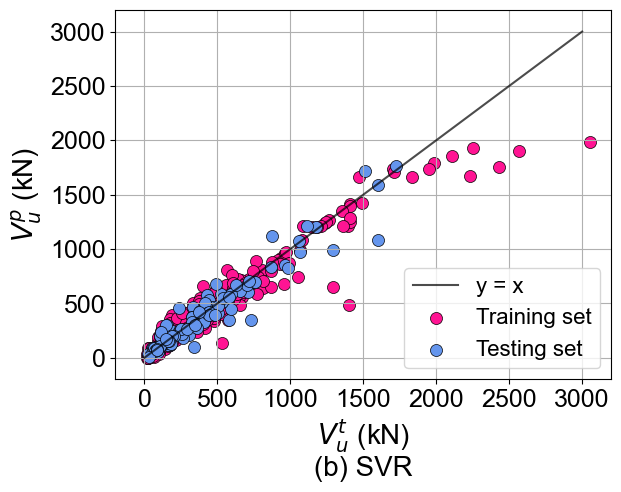

In [12]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

colors1 = 'deeppink' 
colors2 = 'cornflowerblue'

plt.figure()
plt.title('(b) SVR',fontproperties = 'Arial', size = 20, y=-0.3, va='bottom', ha='center')
plt.plot(xx, yy, linewidth=1.5, c ='black', alpha=0.7)
plt.scatter(y_train, Z_1, marker='o', s=75, c=colors1, linewidth=0.5, edgecolors='black')
plt.scatter(y_test, Z_2, marker='o', s=75, c=colors2, linewidth=0.5, edgecolors='black')
plt.grid()

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Arial', size = 18)
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000], fontproperties = 'Arial', size = 18)

font1 = {'family' : 'Arial', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('$V_{u}^{t}$ (kN)', font1)
plt.ylabel('$V_{u}^{p}$ (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])

plt.legend(['y = x','Training set','Testing set'], loc = 'lower right', prop={'family' : 'Arial', 'weight' : 'normal', 'size' : 16,})

plt.savefig('Prediction_SVR.JPG', dpi=500, bbox_inches = 'tight')
plt.show()

# 3 KNN

In [13]:
# building the KNN model 

from sklearn.neighbors import KNeighborsRegressor
regr3 = KNeighborsRegressor(leaf_size=10, n_neighbors=5, weights='distance')

# 10-fold cv results for hyper-parameter validation
scores = cross_val_score (regr3, X_train, y_train, cv=10, scoring='r2', n_jobs = -1)
print('10-fold mean r2:', np.mean(scores))

10-fold mean r2: 0.830095864358561


In [14]:
# trainning the model
regr3.fit(X_train, y_train) 
Z_1 = regr3.predict(X_train)
Z_2 = regr3.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

Training R2: 0.9998235773963075 RMSE: 5.52193714340957 MAE: 0.6695748846414558 MAPE: 0.13731475190809775 %
Testing R2: 0.8291158674968921 RMSE: 150.58730965786015 MAE: 90.21909220903903 MAPE: 23.16232472215633 %


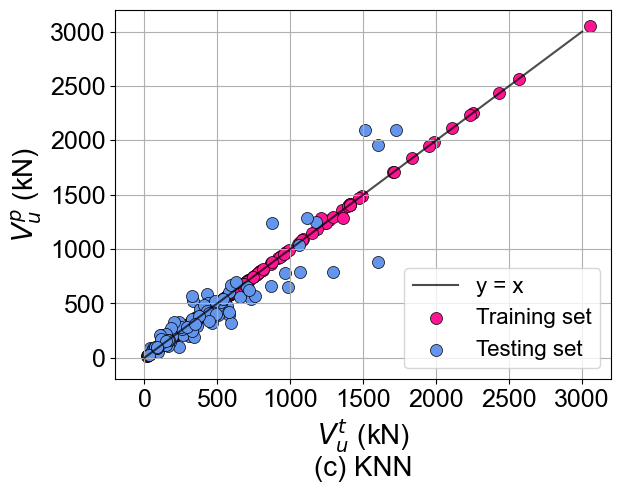

In [15]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

colors1 = 'deeppink' 
colors2 = 'cornflowerblue'

plt.figure()
plt.title('(c) KNN',fontproperties = 'Arial', size = 20, y=-0.3, va='bottom', ha='center')
plt.plot(xx, yy, linewidth=1.5, c ='black', alpha=0.7)
plt.scatter(y_train, Z_1, marker='o', s=75, c=colors1, linewidth=0.5, edgecolors='black')
plt.scatter(y_test, Z_2, marker='o', s=75, c=colors2, linewidth=0.5, edgecolors='black')
plt.grid()

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Arial', size = 18)
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000], fontproperties = 'Arial', size = 18)

font1 = {'family' : 'Arial', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('$V_{u}^{t}$ (kN)', font1)
plt.ylabel('$V_{u}^{p}$ (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])

plt.legend(['y = x','Training set','Testing set'], loc = 'lower right', prop={'family' : 'Arial', 'weight' : 'normal', 'size' : 16,})

plt.savefig('Prediction_KNN.JPG', dpi=500, bbox_inches = 'tight')
plt.show()

# 4 DT

In [16]:
# building the DT model 
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
regr4 = DecisionTreeRegressor(min_samples_leaf=1, min_samples_split=5, random_state=10)

# 10-fold cv results for hyper-parameter validation
scores = cross_val_score (regr4, X_train, y_train, cv=10, scoring='r2', n_jobs = -1)
print('10-fold mean r2:', np.mean(scores))

10-fold mean r2: 0.8403318235105013


In [17]:
# trainning the model
regr4.fit(X_train, y_train) 
Z_1 = regr4.predict(X_train)
Z_2 = regr4.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

Training R2: 0.9863812365445966 RMSE: 48.515798479569895 MAE: 22.358783542273517 MAPE: 6.342071908696996 %
Testing R2: 0.7823608295577033 RMSE: 169.94407834637352 MAE: 92.10182729377229 MAPE: 31.65818756620376 %


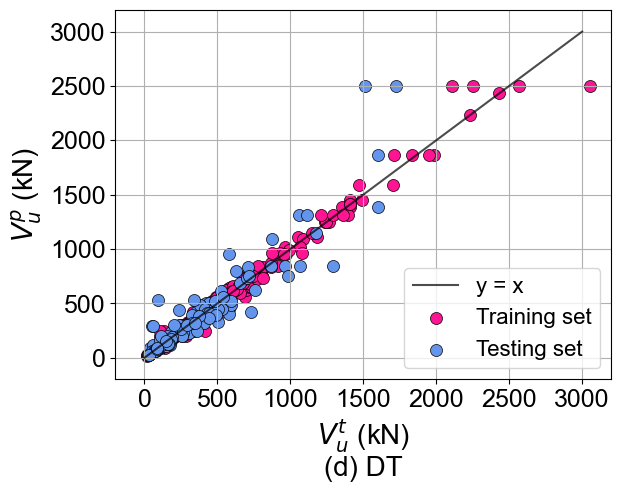

In [18]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

colors1 = 'deeppink'
colors2 = 'cornflowerblue'

plt.figure()
plt.title('(d) DT',fontproperties = 'Arial', size = 20, y=-0.3, va='bottom', ha='center')
plt.plot(xx, yy, linewidth=1.5, c ='black', alpha=0.7)
plt.scatter(y_train, Z_1, marker='o', s=75, c=colors1, linewidth=0.5, edgecolors='black')
plt.scatter(y_test, Z_2, marker='o', s=75, c=colors2, linewidth=0.5, edgecolors='black')
plt.grid()

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Arial', size = 18)
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000], fontproperties = 'Arial', size = 18)

font1 = {'family' : 'Arial', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('$V_{u}^{t}$ (kN)', font1)
plt.ylabel('$V_{u}^{p}$ (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])

plt.legend(['y = x','Training set','Testing set'], loc = 'lower right', prop={'family' : 'Arial', 'weight' : 'normal', 'size' : 16,})

plt.savefig('Prediction_DT.JPG', dpi=500, bbox_inches = 'tight')
plt.show()

# 5 RF

In [19]:
# building the RF model 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
regr5 =  RandomForestRegressor(min_samples_leaf=1, min_samples_split=1, n_estimators=500, random_state = 10)

# 10-fold cv results for hyper-parameter validation
scores = cross_val_score (regr5, X_train, y_train, cv=10, scoring='r2', n_jobs = -1)
print('10-fold mean r2:', np.mean(scores))

10-fold mean r2: 0.8877699831862376


In [20]:
# trainning the model
regr5.fit(X_train, y_train) 
Z_1 = regr5.predict(X_train)
Z_2 = regr5.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

Training R2: 0.9877151114012475 RMSE: 46.078672243878735 MAE: 23.883591171438113 MAPE: 6.80966405593047 %
Testing R2: 0.8657144913404283 RMSE: 133.49102865581017 MAE: 74.46243892940528 MAPE: 20.647619783397907 %


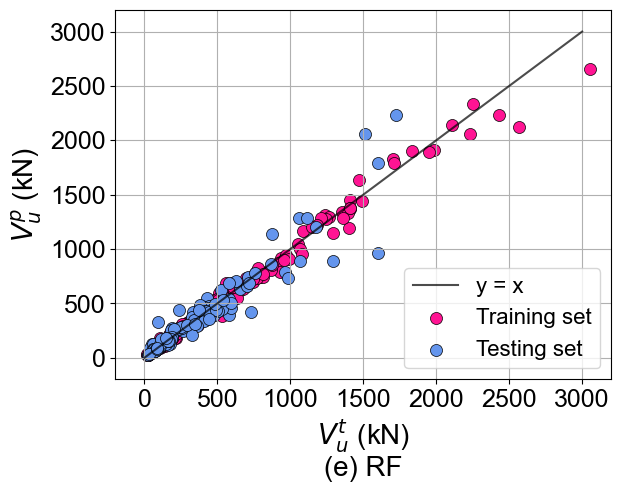

In [21]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

colors1 = 'deeppink'
colors2 = 'cornflowerblue'

plt.figure()
plt.title('(e) RF',fontproperties = 'Arial', size = 20, y=-0.3, va='bottom', ha='center')
plt.plot(xx, yy, linewidth=1.5, c ='black', alpha=0.7)
plt.scatter(y_train, Z_1, marker='o', s=75, c=colors1, linewidth=0.5, edgecolors='black')
plt.scatter(y_test, Z_2, marker='o', s=75, c=colors2, linewidth=0.5, edgecolors='black')
plt.grid()

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Arial', size = 18)
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000], fontproperties = 'Arial', size = 18)

font1 = {'family' : 'Arial', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('$V_{u}^{t}$ (kN)', font1)
plt.ylabel('$V_{u}^{p}$ (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])

plt.legend(['y = x','Training set','Testing set'], loc = 'lower right', prop={'family' : 'Arial', 'weight' : 'normal', 'size' : 16,})

plt.savefig('Prediction_RF.JPG', dpi=500, bbox_inches = 'tight')
plt.show()

# 6 AdaBoost

In [22]:
# building the AdaBoost model 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor 
dt = DecisionTreeRegressor(random_state=10)
regr6 =   AdaBoostRegressor(dt, learning_rate=0.2, loss='exponential', n_estimators=400, random_state=10)

# 10-fold cv results for hyper-parameter validation
scores = cross_val_score (regr6, X_train, y_train, cv=10, scoring='r2', n_jobs = -1)
print('10-fold mean r2:', np.mean(scores))

10-fold mean r2: 0.901009643966181


In [23]:
# trainning the model
regr6.fit(X_train, y_train) 
Z_1 = regr6.predict(X_train)
Z_2 = regr6.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

Training R2: 0.9993527043145699 RMSE: 10.577077858364644 MAE: 4.244215113250972 MAPE: 6.005102405731731 %
Testing R2: 0.8631729664306246 RMSE: 134.74835161020906 MAE: 76.82897184038293 MAPE: 20.73604349748475 %


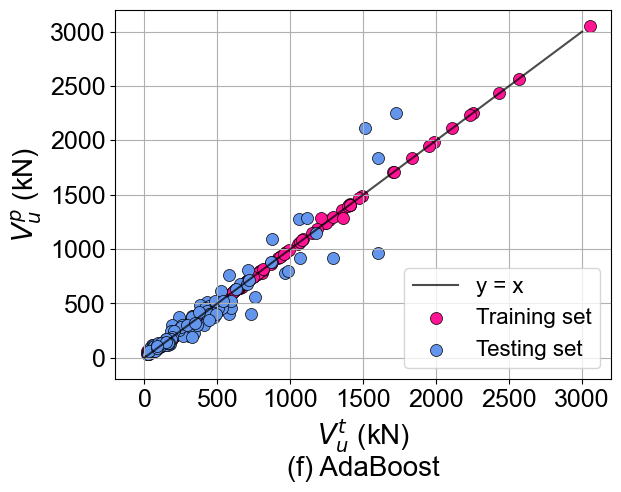

In [24]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

colors1 = 'deeppink' 
colors2 = 'cornflowerblue'

plt.figure()
plt.title('(f) AdaBoost',fontproperties = 'Arial', size = 20, y=-0.3, va='bottom', ha='center')
plt.plot(xx, yy, linewidth=1.5, c ='black', alpha=0.7)
plt.scatter(y_train, Z_1, marker='o', s=75, c=colors1, linewidth=0.5, edgecolors='black')
plt.scatter(y_test, Z_2, marker='o', s=75, c=colors2, linewidth=0.5, edgecolors='black')
plt.grid()

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Arial', size = 18)
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000], fontproperties = 'Arial', size = 18)

font1 = {'family' : 'Arial', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('$V_{u}^{t}$ (kN)', font1)
plt.ylabel('$V_{u}^{p}$ (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])

plt.legend(['y = x','Training set','Testing set'], loc = 'lower right', prop={'family' : 'Arial', 'weight' : 'normal', 'size' : 16,})

plt.savefig('Prediction_AdaBoost.JPG', dpi=500, bbox_inches = 'tight')
plt.show()

# 7 GBM

In [25]:
# building the GBM model 
from sklearn.ensemble import GradientBoostingRegressor
regr7 =  GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=4, min_samples_split=1, n_estimators=500, random_state=10)

# 10-fold cv results for hyper-parameter validation
scores = cross_val_score (regr7, X_train, y_train, cv=10, scoring='r2', n_jobs = -1)
print('10-fold mean r2:', np.mean(scores))

10-fold mean r2: 0.9199897468451784


In [26]:
# trainning the model
regr7.fit(X_train, y_train) 
Z_1 = regr7.predict(X_train)
Z_2 = regr7.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

Training R2: 0.9990424891591064 RMSE: 12.864301053264462 MAE: 8.145452453422617 MAPE: 3.5817248945291853 %
Testing R2: 0.9339370045175267 RMSE: 93.63034774076569 MAE: 58.153023106165485 MAPE: 15.688243833560483 %


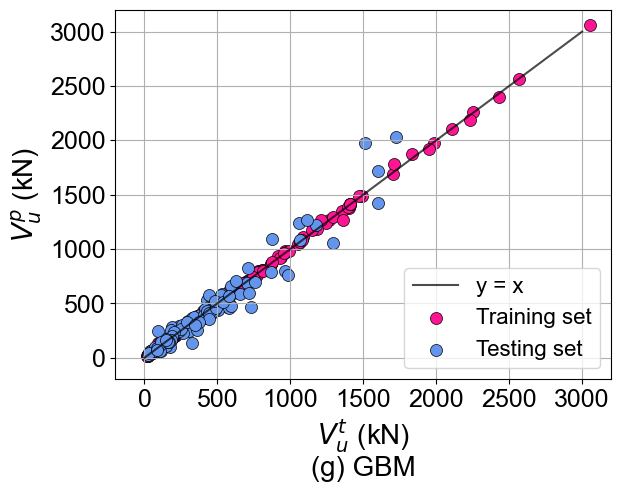

In [27]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

colors1 = 'deeppink'
colors2 = 'cornflowerblue'

plt.figure()
plt.title('(g) GBM',fontproperties = 'Arial', size = 20, y=-0.3, va='bottom', ha='center')
plt.plot(xx, yy, linewidth=1.5, c ='black', alpha=0.7)
plt.scatter(y_train, Z_1, marker='o', s=75, c=colors1, linewidth=0.5, edgecolors='black')
plt.scatter(y_test, Z_2, marker='o', s=75, c=colors2, linewidth=0.5, edgecolors='black')
plt.grid()

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Arial', size = 18)
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000], fontproperties = 'Arial', size = 18)

font1 = {'family' : 'Arial', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('$V_{u}^{t}$ (kN)', font1)
plt.ylabel('$V_{u}^{p}$ (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])

plt.legend(['y = x','Training set','Testing set'], loc = 'lower right', prop={'family' : 'Arial', 'weight' : 'normal', 'size' : 16,})

plt.savefig('Prediction_GBM.JPG', dpi=500, bbox_inches = 'tight')
plt.show()

# 8 LGBM

In [28]:
# building the LGBM model 
from lightgbm import LGBMRegressor
regr8 =  LGBMRegressor(learning_rate=0.2, min_child_samples=30, n_estimators=500, num_leaves=30)

# 10-fold cv results for hyper-parameter validation
scores = cross_val_score (regr8, X_train, y_train, cv=10, scoring='r2', n_jobs = -1)
print('10-fold mean r2:', np.mean(scores))

10-fold mean r2: 0.9047662537678413


In [29]:
# trainning the model
regr8.fit(X_train, y_train) 
Z_1 = regr8.predict(X_train)
Z_2 = regr8.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

Training R2: 0.9967496876863515 RMSE: 23.701557825290283 MAE: 13.091172737587305 MAPE: 4.15768546183648 %
Testing R2: 0.9147604553532248 RMSE: 106.35503770427445 MAE: 65.40450502969392 MAPE: 17.865378105336344 %


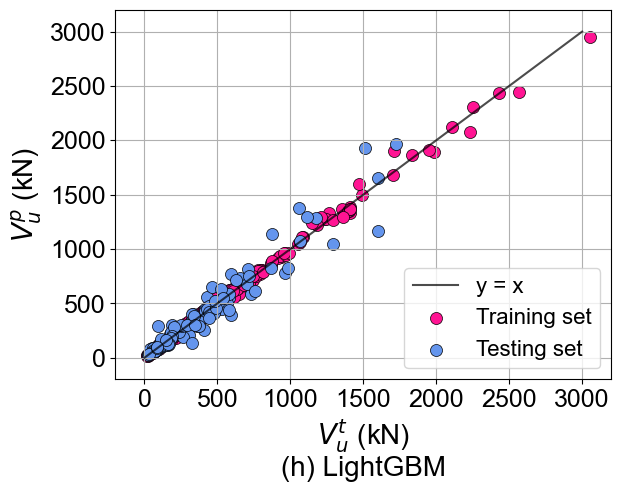

In [30]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

colors1 = 'deeppink'
colors2 = 'cornflowerblue'

plt.figure()
plt.title('(h) LightGBM',fontproperties = 'Arial', size = 20, y=-0.3, va='bottom', ha='center')
plt.plot(xx, yy, linewidth=1.5, c ='black', alpha=0.7)
plt.scatter(y_train, Z_1, marker='o', s=75, c=colors1, linewidth=0.5, edgecolors='black')
plt.scatter(y_test, Z_2, marker='o', s=75, c=colors2, linewidth=0.5, edgecolors='black')
plt.grid()

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Arial', size = 18)
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000], fontproperties = 'Arial', size = 18)

font1 = {'family' : 'Arial', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('$V_{u}^{t}$ (kN)', font1)
plt.ylabel('$V_{u}^{p}$ (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])

plt.legend(['y = x','Training set','Testing set'], loc = 'lower right', prop={'family' : 'Arial', 'weight' : 'normal', 'size' : 16,})

plt.savefig('Prediction_LightGBM.JPG', dpi=500, bbox_inches = 'tight')
plt.show()

# 9 CatBoost

In [31]:
# building the CatBoost model 
from catboost import CatBoostRegressor
regr9 =  CatBoostRegressor(l2_leaf_reg=0.1, learning_rate=0.05)

# 10-fold cv results for hyper-parameter validation
scores = cross_val_score (regr9, X_train, y_train, cv=10, scoring='r2', n_jobs = -1)
print('10-fold mean r2:', np.mean(scores))

10-fold mean r2: 0.9186917709070392


In [32]:
# trainning the model
regr9.fit(X_train, y_train) 
Z_1 = regr9.predict(X_train)
Z_2 = regr9.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

0:	learn: 399.2941967	total: 55.9ms	remaining: 55.9s
1:	learn: 384.5305784	total: 57.4ms	remaining: 28.7s
2:	learn: 370.9920000	total: 58.7ms	remaining: 19.5s
3:	learn: 356.3937170	total: 60.6ms	remaining: 15.1s
4:	learn: 342.7046643	total: 61.8ms	remaining: 12.3s
5:	learn: 329.0368750	total: 63.2ms	remaining: 10.5s
6:	learn: 317.5020894	total: 64.9ms	remaining: 9.21s
7:	learn: 306.7555982	total: 66.4ms	remaining: 8.24s
8:	learn: 294.5995483	total: 67.8ms	remaining: 7.46s
9:	learn: 284.1216862	total: 69ms	remaining: 6.83s
10:	learn: 273.6823801	total: 70.3ms	remaining: 6.32s
11:	learn: 264.8522703	total: 71.6ms	remaining: 5.89s
12:	learn: 255.4605244	total: 72.9ms	remaining: 5.54s
13:	learn: 246.9837800	total: 74.2ms	remaining: 5.22s
14:	learn: 240.0553926	total: 75.5ms	remaining: 4.96s
15:	learn: 233.8633147	total: 76.9ms	remaining: 4.73s
16:	learn: 227.4453146	total: 78.1ms	remaining: 4.52s
17:	learn: 220.0131918	total: 79.4ms	remaining: 4.33s
18:	learn: 213.4841665	total: 80.7ms	rem

170:	learn: 40.4117031	total: 324ms	remaining: 1.57s
171:	learn: 40.1780425	total: 325ms	remaining: 1.57s
172:	learn: 39.9541575	total: 327ms	remaining: 1.56s
173:	learn: 39.7865498	total: 329ms	remaining: 1.56s
174:	learn: 39.4575418	total: 330ms	remaining: 1.55s
175:	learn: 39.2558335	total: 331ms	remaining: 1.55s
176:	learn: 39.0967805	total: 333ms	remaining: 1.55s
177:	learn: 38.8868125	total: 334ms	remaining: 1.54s
178:	learn: 38.7605473	total: 336ms	remaining: 1.54s
179:	learn: 38.6422662	total: 337ms	remaining: 1.54s
180:	learn: 38.4050066	total: 339ms	remaining: 1.53s
181:	learn: 38.2107009	total: 341ms	remaining: 1.53s
182:	learn: 38.0141740	total: 342ms	remaining: 1.53s
183:	learn: 37.8811563	total: 344ms	remaining: 1.52s
184:	learn: 37.5425127	total: 346ms	remaining: 1.52s
185:	learn: 37.4504102	total: 348ms	remaining: 1.52s
186:	learn: 37.2814761	total: 349ms	remaining: 1.52s
187:	learn: 37.1972910	total: 351ms	remaining: 1.51s
188:	learn: 37.0369754	total: 352ms	remaining:

370:	learn: 21.1323942	total: 608ms	remaining: 1.03s
371:	learn: 21.0697818	total: 610ms	remaining: 1.03s
372:	learn: 21.0198844	total: 612ms	remaining: 1.03s
373:	learn: 21.0011227	total: 613ms	remaining: 1.03s
374:	learn: 20.9716381	total: 615ms	remaining: 1.02s
375:	learn: 20.9465014	total: 617ms	remaining: 1.02s
376:	learn: 20.9076997	total: 618ms	remaining: 1.02s
377:	learn: 20.8777282	total: 620ms	remaining: 1.02s
378:	learn: 20.7967100	total: 621ms	remaining: 1.02s
379:	learn: 20.7619820	total: 623ms	remaining: 1.02s
380:	learn: 20.7301819	total: 625ms	remaining: 1.01s
381:	learn: 20.6598649	total: 627ms	remaining: 1.01s
382:	learn: 20.6050718	total: 629ms	remaining: 1.01s
383:	learn: 20.5176569	total: 631ms	remaining: 1.01s
384:	learn: 20.4826911	total: 632ms	remaining: 1.01s
385:	learn: 20.4448256	total: 633ms	remaining: 1.01s
386:	learn: 20.4272484	total: 635ms	remaining: 1s
387:	learn: 20.3478293	total: 636ms	remaining: 1s
388:	learn: 20.2883408	total: 638ms	remaining: 1s
38

569:	learn: 13.5731555	total: 892ms	remaining: 673ms
570:	learn: 13.5389934	total: 893ms	remaining: 671ms
571:	learn: 13.5075468	total: 896ms	remaining: 670ms
572:	learn: 13.4897290	total: 898ms	remaining: 669ms
573:	learn: 13.4763203	total: 900ms	remaining: 668ms
574:	learn: 13.4579963	total: 901ms	remaining: 666ms
575:	learn: 13.4169678	total: 903ms	remaining: 665ms
576:	learn: 13.4007611	total: 905ms	remaining: 664ms
577:	learn: 13.3814008	total: 907ms	remaining: 662ms
578:	learn: 13.3329908	total: 908ms	remaining: 660ms
579:	learn: 13.3237520	total: 910ms	remaining: 659ms
580:	learn: 13.2875528	total: 913ms	remaining: 659ms
581:	learn: 13.2685704	total: 915ms	remaining: 657ms
582:	learn: 13.2537737	total: 917ms	remaining: 656ms
583:	learn: 13.2263874	total: 919ms	remaining: 654ms
584:	learn: 13.1924833	total: 921ms	remaining: 653ms
585:	learn: 13.1618408	total: 922ms	remaining: 652ms
586:	learn: 13.1394430	total: 924ms	remaining: 650ms
587:	learn: 13.1323106	total: 926ms	remaining:

735:	learn: 10.2345262	total: 1.16s	remaining: 417ms
736:	learn: 10.2250603	total: 1.16s	remaining: 415ms
737:	learn: 10.2056188	total: 1.17s	remaining: 414ms
738:	learn: 10.1992738	total: 1.17s	remaining: 413ms
739:	learn: 10.1723915	total: 1.17s	remaining: 411ms
740:	learn: 10.1621361	total: 1.17s	remaining: 409ms
741:	learn: 10.1613588	total: 1.17s	remaining: 407ms
742:	learn: 10.1317647	total: 1.17s	remaining: 406ms
743:	learn: 10.1156810	total: 1.18s	remaining: 404ms
744:	learn: 10.0965968	total: 1.18s	remaining: 403ms
745:	learn: 10.0849754	total: 1.18s	remaining: 401ms
746:	learn: 10.0541509	total: 1.18s	remaining: 400ms
747:	learn: 10.0388771	total: 1.18s	remaining: 398ms
748:	learn: 10.0269561	total: 1.18s	remaining: 397ms
749:	learn: 10.0138761	total: 1.18s	remaining: 395ms
750:	learn: 10.0061814	total: 1.19s	remaining: 393ms
751:	learn: 9.9800351	total: 1.19s	remaining: 392ms
752:	learn: 9.9654035	total: 1.19s	remaining: 390ms
753:	learn: 9.9522716	total: 1.19s	remaining: 38

933:	learn: 8.1062463	total: 1.45s	remaining: 102ms
934:	learn: 8.0955674	total: 1.45s	remaining: 101ms
935:	learn: 8.0939965	total: 1.45s	remaining: 99.1ms
936:	learn: 8.0882224	total: 1.45s	remaining: 97.6ms
937:	learn: 8.0762221	total: 1.45s	remaining: 96ms
938:	learn: 8.0716662	total: 1.45s	remaining: 94.5ms
939:	learn: 8.0580370	total: 1.46s	remaining: 92.9ms
940:	learn: 8.0515810	total: 1.46s	remaining: 91.4ms
941:	learn: 8.0430084	total: 1.46s	remaining: 89.8ms
942:	learn: 8.0356645	total: 1.46s	remaining: 88.3ms
943:	learn: 8.0313237	total: 1.46s	remaining: 86.8ms
944:	learn: 8.0084602	total: 1.46s	remaining: 85.3ms
945:	learn: 7.9991787	total: 1.47s	remaining: 83.7ms
946:	learn: 7.9956938	total: 1.47s	remaining: 82.1ms
947:	learn: 7.9883909	total: 1.47s	remaining: 80.6ms
948:	learn: 7.9837488	total: 1.47s	remaining: 79ms
949:	learn: 7.9737242	total: 1.47s	remaining: 77.4ms
950:	learn: 7.9699225	total: 1.47s	remaining: 75.9ms
951:	learn: 7.9485584	total: 1.47s	remaining: 74.3ms

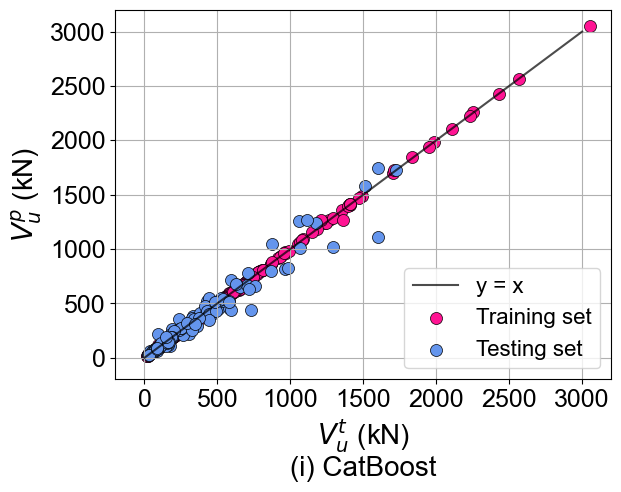

In [33]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

colors1 = 'deeppink'
colors2 = 'cornflowerblue'

plt.figure()
plt.title('(i) CatBoost',fontproperties = 'Arial', size = 20, y=-0.3, va='bottom', ha='center')
plt.plot(xx, yy, linewidth=1.5, c ='black', alpha=0.7)
plt.scatter(y_train, Z_1, marker='o', s=75, c=colors1, linewidth=0.5, edgecolors='black')
plt.scatter(y_test, Z_2, marker='o', s=75, c=colors2, linewidth=0.5, edgecolors='black')
plt.grid()

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Arial', size = 18)
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000], fontproperties = 'Arial', size = 18)

font1 = {'family' : 'Arial', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('$V_{u}^{t}$ (kN)', font1)
plt.ylabel('$V_{u}^{p}$ (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])

plt.legend(['y = x','Training set','Testing set'], loc = 'lower right', prop={'family' : 'Arial', 'weight' : 'normal', 'size' : 16,})

plt.savefig('Prediction_CatBoost.JPG', dpi=500, bbox_inches = 'tight')
plt.show()

# 10 XGBoost

In [34]:
# building the XGBoost model 
from xgboost import XGBRegressor
regr10 =  XGBRegressor(learning_rate=0.2, min_child_weight=4, n_estimators=300)

# 10-fold cv results for hyper-parameter validation
scores = cross_val_score (regr10, X_train, y_train, cv=10, scoring='r2', n_jobs = -1)
print('10-fold mean r2:', np.mean(scores))

10-fold mean r2: 0.9138358841863274


In [35]:
# trainning the model
regr10.fit(X_train, y_train) 
Z_1 = regr10.predict(X_train)
Z_2 = regr10.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

Training R2: 0.9997449359560645 RMSE: 6.6395548896841055 MAE: 2.890022354736855 MAPE: 1.3140559129582698 %
Testing R2: 0.9162461893150586 RMSE: 105.4240735911465 MAE: 61.44436445718705 MAPE: 17.970054788027177 %


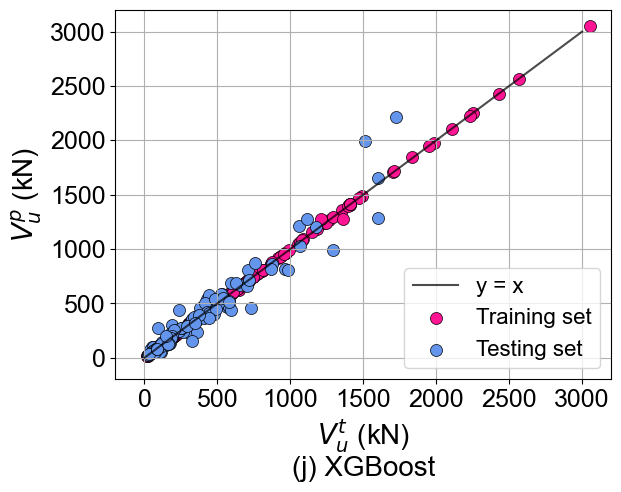

In [36]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

colors1 = 'deeppink'
colors2 = 'cornflowerblue'

plt.figure()
plt.title('(j) XGBoost',fontproperties = 'Arial', size = 20, y=-0.3, va='bottom', ha='center')
plt.plot(xx, yy, linewidth=1.5, c ='black', alpha=0.7)
plt.scatter(y_train, Z_1, marker='o', s=75, c=colors1, linewidth=0.5, edgecolors='black')
plt.scatter(y_test, Z_2, marker='o', s=75, c=colors2, linewidth=0.5, edgecolors='black')
plt.grid()

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Arial', size = 18)
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000], fontproperties = 'Arial', size = 18)

font1 = {'family' : 'Arial', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('$V_{u}^{t}$ (kN)', font1)
plt.ylabel('$V_{u}^{p}$ (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])

plt.legend(['y = x','Training set','Testing set'], loc = 'lower right', prop={'family' : 'Arial', 'weight' : 'normal', 'size' : 16,})

plt.savefig('Prediction_XGBoost.JPG', dpi=500, bbox_inches = 'tight')
plt.show()